# Research Question:
Are LLMs sensitive to syntactic ambiguity?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [ ]:
data = [
    {"context": "The woman saw the man with the telescope.", "fragment": "The person with the telescope was the", "answers": (" woman", " man")},
    {"context": "The old men and women sat on the bench.", "fragment": "It was the woman who appeared to be", "answers": (" young", " old")},
    {"context": "Flying planes can be dangerous.", "fragment": "In discussions about aviation risks, it's often the", "answers": (" flying", " planes")},
    {"context": "The chicken is ready to eat.", "fragment": "The chicken was ready for", "answers": (" eating", " food")},
    {"context": "Visiting relatives can be annoying.", "fragment": "During the holidays, the most annoying aspect can be", "answers": (" visiting the relatives", " relatives who are visiting")},
    {"context": "The baby saw an elephant in their pajamas.", "fragment": "The one in pajamas was the", "answers": (" baby", " elephant")},
    {"context": "The girl saw the boy with binoculars.", "fragment": "The one holding the binoculars was the", "answers": (" girl", " boy")},
    {"context": "Jane told Sue about her new job.", "fragment": "The new job belonged to", "answers": (" Jane", " Sue")},
    {"context": "The police arrested the person with a warrant.", "fragment": "The warrant was held by the", "answers": (" police", " person")},
    {"context": "He saw that gas can explode.", "fragment": "The danger came from the", "answers": (" gas", " can")}
]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")
model.eval()

def next_seq_prob(model, tokenizer, sentence, candidate):
    text = f"{sentence}{candidate}"
    inputs = tokenizer.encode(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(inputs, labels=inputs)
    logits = outputs.logits[0, -1, :]
    probs = torch.softmax(logits, dim=-1)
    token_id = tokenizer.encode(candidate, add_special_tokens=False)[-1]
    prob = probs[token_id].item()
    return prob

def surprisal(probability):
    return -np.log2(probability)

all_results = []

for item in data:
    context = item['context']
    question = item['fragment']
    sentence = f"{context} {question}"

    temp_results = []

    for answer in item['answers']:
        full_sentence = f"{sentence}{answer}"
        prob = next_seq_prob(model, tokenizer, sentence, answer)
        temp_results.append({
            'Context': context,
            'Question': question,
            'Answer': answer,
            'Probability': prob,
            'Surprisal': surprisal(prob)
        })

    #calculating surprisal difference
    if len(temp_results) == 2:
        surprisal_diff = abs(temp_results[0]['Surprisal'] - temp_results[1]['Surprisal'])
        temp_results[0]['Surprisal Difference'] = surprisal_diff
        temp_results[1]['Surprisal Difference'] = surprisal_diff

    all_results.extend(temp_results)

df_results = pd.DataFrame(all_results)
df_results = df_results.sort_values(by='Surprisal Difference', ascending=False)
print(df_results)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


                                           Context  \
4                  Flying planes can be dangerous.   
5                  Flying planes can be dangerous.   
17  The police arrested the person with a warrant.   
16  The police arrested the person with a warrant.   
15                Jane told Sue about her new job.   
14                Jane told Sue about her new job.   
12           The girl saw the boy with binoculars.   
13           The girl saw the boy with binoculars.   
8              Visiting relatives can be annoying.   
9              Visiting relatives can be annoying.   
2          The old men and women sat on the bench.   
3          The old men and women sat on the bench.   
0        The woman saw the man with the telescope.   
1        The woman saw the man with the telescope.   
18                    He saw that gas can explode.   
19                    He saw that gas can explode.   
11      The baby saw an elephant in their pajamas.   
10      The baby saw an elep

In [ ]:
avg_surprisal = df_results['Surprisal'].mean()
print("The average surprisal is ",avg_surprisal)

avg_surprisal_difference = df_results['Surprisal Difference'].mean()
print("The average surprisal difference is ",avg_surprisal_difference)

The average surprisal is  11.765947271121554
The average surprisal difference is  1.7207814365449763


<ipython-input-5-c0c75461741d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Context', y='Surprisal Difference', data=df_results, palette='viridis')


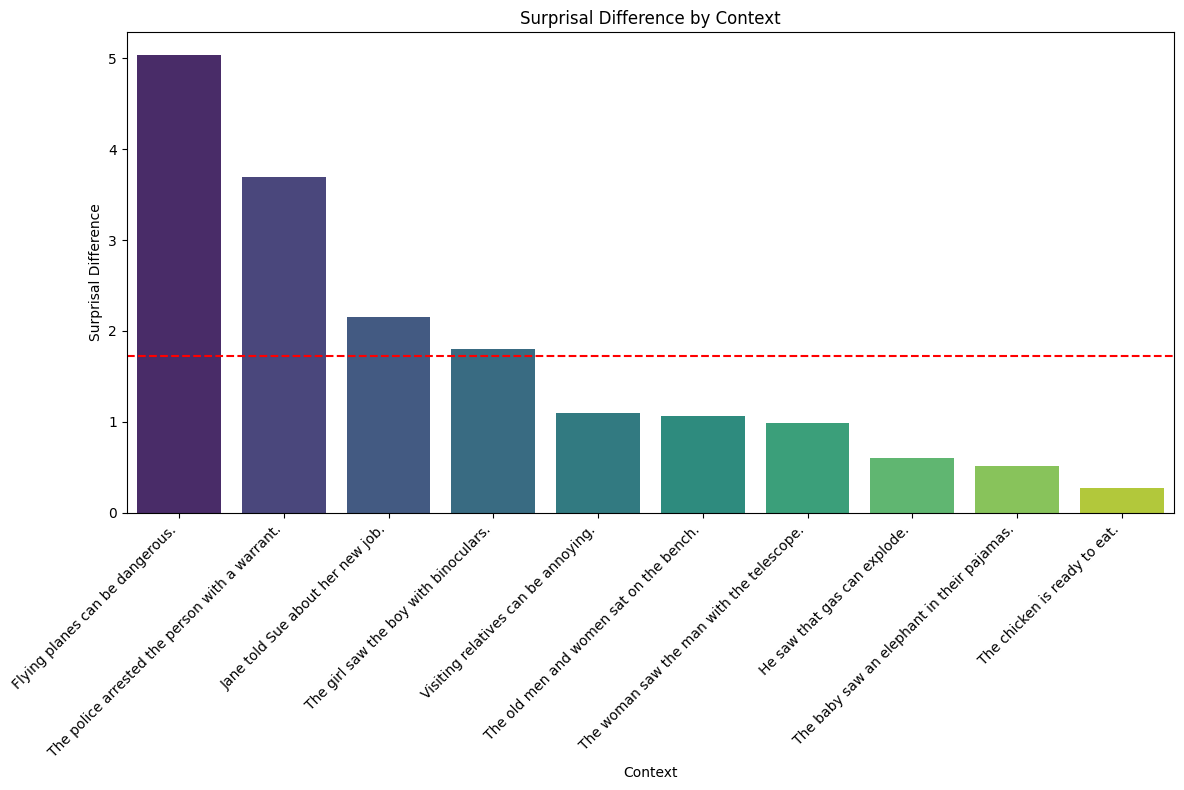

In [ ]:
#barplot
plt.figure(figsize=(12, 8))
sns.barplot(x='Context', y='Surprisal Difference', data=df_results, palette='viridis')

plt.axhline(avg_surprisal_difference, color='red', linestyle='--', label=f'Average: {avg_surprisal_difference:.2f}')

plt.xticks(rotation=45, ha="right")
plt.title('Surprisal Difference by Context')
plt.xlabel('Context')
plt.ylabel('Surprisal Difference')
plt.tight_layout()

plt.show()


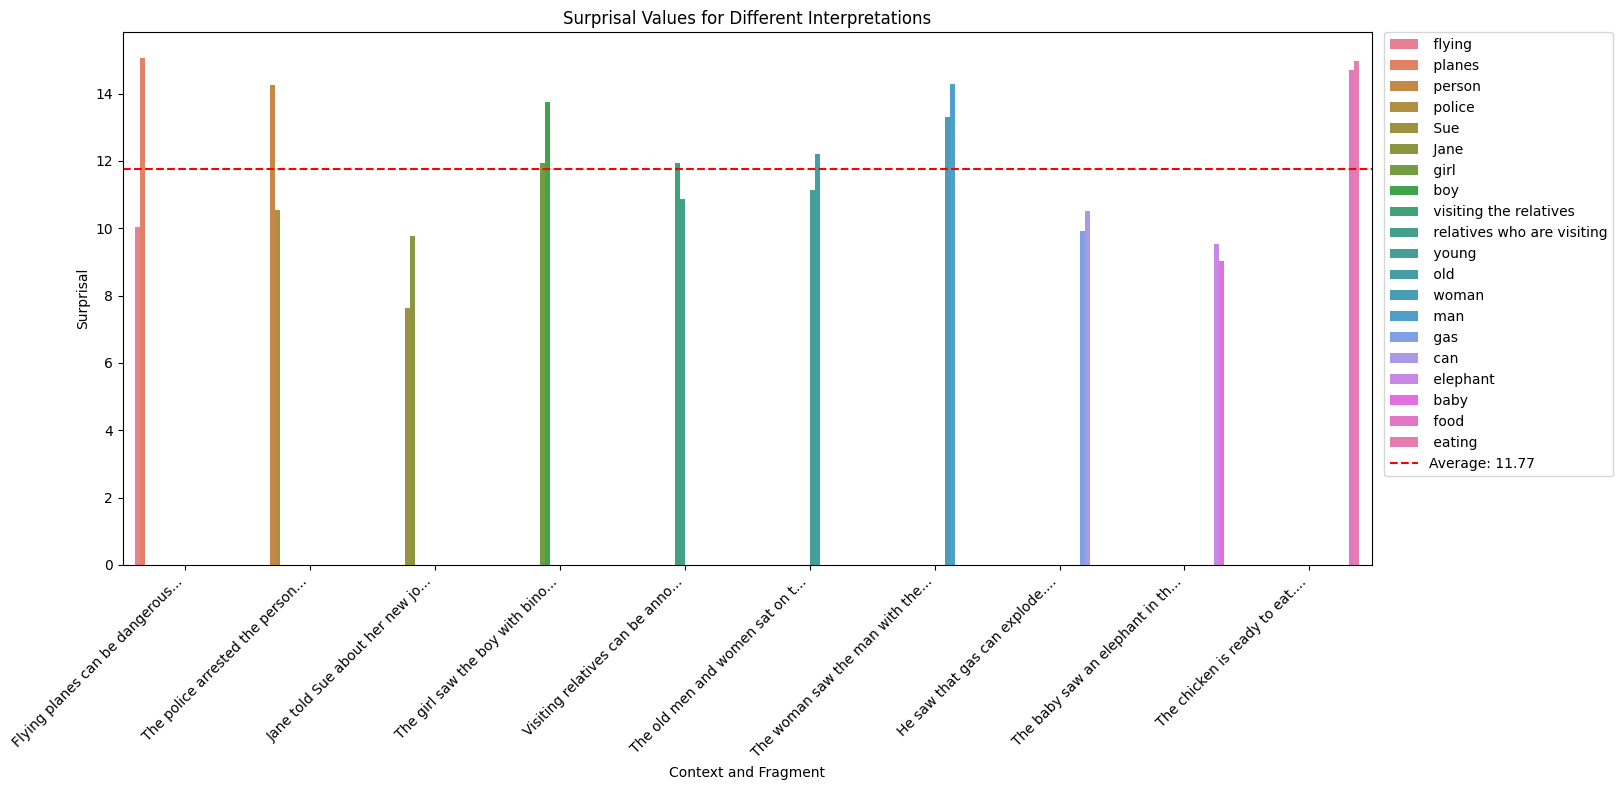

In [ ]:
def shorten(context):
    return context[:30] + '...'

df_results['Shortened Context'] = df_results['Context'].apply(shorten)

#barplot
plt.figure(figsize=(14, 8))
sns.barplot(data=df_results, x='Shortened Context', y='Surprisal', hue='Answer', dodge=True)

plt.axhline(avg_surprisal, color='red', linestyle='--', label=f'Average: {avg_surprisal:.2f}')

plt.xticks(rotation=45, ha="right")
plt.title('Surprisal Values for Different Interpretations')
plt.xlabel('Context and Fragment')
plt.ylabel('Surprisal')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

plt.show()


# Potential Issues with Stimuli
The stimuli chosen was to diversify the place where the ambiguity may take place, whether that be the start or end of the sentence. Some potential issues with the stimuli is having a longer answer choice. I believe that the syntactic ambiguity of "Visiting relatives can be annoying." is a good addition to looking at syntactic ambiguity as both people and LLMs could be confused on how it should be interpreted. But due to this complexity, it was hard to come up with a sentence fragment that included one word to complete the fragment. So, I chose to include it instead of opting for a different stimuli context.

I also looked at seeing how context, question, and answer would play a role in the surprisal, but found that I had to stray away from polar questions as it could create bias in the LLMs answer. This is why I reverted back to fragments and candidates, while trying to minimize the word length of the candidates.
  
It would be interesting to look into stimuli that have lower surprisal for both answers given the context, as much of the stimuli have a high surprisal value.

# Discussion
This project shows how an LLM interprets syntactically ambiguous sentences. A higher surprisal would indicate that the LLM does not expect the answer to the fragment/question.

For the most part out of the 10 stimuli, 2 have a large increase in surprisal in comparison to the mean of the surprisal difference. Like humans I expected LLMs to be a little confused on how to interpret a syntactically ambiguous sentence, which would result in a lower surprisal difference. This indicates that an LLM, for the most part, can predict either answer that was used. Written out, even humans get confused by these syntactically ambiguous sentences. This can be paralleled by the LLMs interpretation of the input context and finishing the fragment.  
  
Because context plays a large role in LLMs and understanding written text, it makes sense how police is more likely to be associated with warrant whereas a woman is less likely to be associated to having a warrant. The same can be said with danger being in flying and not the planes themselves as it is the act of flying that is more dangerous than the plane itself. This results in the larger difference between surprisal values.

<!-- In the English language it is common for an adjective to c-command and be sisters with noun phrases. So in the sentence "The old men and women sat on the bench.", 'old' would commonly be sisters with the phrase 'men and women'. I believe that human's initial thought of whether or not the women were old would follow the LLMs output of believing that it is more likely that the women are old than to not be in the context and structure of the sentence.   -->
  
I believe that if this experiment was conducted with spoken language, the emphasis on certain words would play a huge role in determining what would be the correct meaning of the sentence, and lead to there being a correct answer to the question. But for the context of written language, and neither human nor LLM being able to work with any extra context to the sentence, there is no real correct answer that could be seen from just reading the sentence unless there was added punctuation or different word structure. This brings into light how humans can use outside experiences whereas LLMs can only use what they were trained on. So humans could use their outside experiences to influence them on what they think the sentence most likely means.    
  
Overall, LLMs are sensitive to syntactic ambiguity in the same sense that humans would be in regards to written text.